# Baseline Metrics -- Tabulating from what we have calculated before

## T5-Base: Baseline with HF RM

In [14]:
!pip install kagglehub transformers datasets evaluate rouge-score nltk --quiet

import kagglehub
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
import evaluate
import torch
import torch.nn.functional as F
import nltk
nltk.download("punkt")
nltk.download("wordnet")

# Step 1: Download CNN/DailyMail from KaggleHub
dataset_path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")
print("📁 Dataset downloaded to:", dataset_path)

import pandas as pd
import os

# Step 2: Load subset of test set from the downloaded CSV
csv_path = os.path.join(dataset_path, "cnn_dailymail/test.csv")  # adjust if filename differs
df = pd.read_csv(csv_path)
print(csv_path)
df = df.dropna(subset=["article", "highlights"])  # drop missing
df = df.head(100)  # restrict for faster testing


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


📁 Dataset downloaded to: /kaggle/input/newspaper-text-summarization-cnn-dailymail
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv


In [16]:
# Step 3: Load summarization model (T5-base) and tokenizer
summarizer = AutoModelForSeq2SeqLM.from_pretrained("t5-base").to("cuda")
summarizer_tokenizer = AutoTokenizer.from_pretrained("t5-base")

# Step 4: Load HuggingFace reward model
reward_model = AutoModelForSequenceClassification.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2").to("cuda")
reward_tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")

# Step 5: Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Step 6: Generate summaries and evaluate
generated_summaries, reference_summaries, reward_scores = [], [], []

for _, row in df.iterrows():
    input_text = "summarize: " + row["article"]
    inputs = summarizer_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to("cuda")

    # Generate summary
    summary_ids = summarizer.generate(**inputs, max_new_tokens=100, num_beams=4, early_stopping=True)
    summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Score with reward model
    reward_input = reward_tokenizer(summary, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        reward_output = reward_model(**reward_input)
        score = reward_output.logits[0][0].item()

    # Store
    generated_summaries.append(summary)
    reference_summaries.append(row["highlights"])
    reward_scores.append(score)

# Step 7: Compute metrics
rouge_results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
meteor_result = meteor.compute(predictions=generated_summaries, references=reference_summaries)
avg_reward = sum(reward_scores) / len(reward_scores)

# Step 8: Print results
print("\nEvaluation of T5-base on CNN/DailyMail:")
for k, v in rouge_results.items():
    print(f"{k}: {v:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"Avg Reward Score (DeBERTa-v3): {avg_reward:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



📊 Evaluation of T5-base on CNN/DailyMail:
rouge1: 0.3744
rouge2: 0.1690
rougeL: 0.2706
rougeLsum: 0.3207
METEOR: 0.3236
Avg Reward Score (DeBERTa-v3): -2.2913


## T5-Large

In [17]:
!pip install kagglehub transformers datasets evaluate rouge-score nltk --quiet

import kagglehub
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
import evaluate
import torch
import torch.nn.functional as F
import nltk
nltk.download("punkt")
nltk.download("wordnet")

# Step 1: Download CNN/DailyMail from KaggleHub
dataset_path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")
print("📁 Dataset downloaded to:", dataset_path)

import pandas as pd
import os

# Step 2: Load subset of test set from the downloaded CSV
csv_path = os.path.join(dataset_path, "cnn_dailymail/test.csv")  # adjust if filename differs
df = pd.read_csv(csv_path)
print(csv_path)
df = df.dropna(subset=["article", "highlights"])  # drop missing
df = df.head(100)  # restrict for faster testing


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


📁 Dataset downloaded to: /kaggle/input/newspaper-text-summarization-cnn-dailymail
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv


In [18]:
# Step 3: Load summarization model (T5-base) and tokenizer
summarizer = AutoModelForSeq2SeqLM.from_pretrained("t5-large").to("cuda")
summarizer_tokenizer = AutoTokenizer.from_pretrained("t5-large")

# Step 4: Load HuggingFace reward model
reward_model = AutoModelForSequenceClassification.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2").to("cuda")
reward_tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")

# Step 5: Load evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Step 6: Generate summaries and evaluate
generated_summaries, reference_summaries, reward_scores = [], [], []

for _, row in df.iterrows():
    input_text = "summarize: " + row["article"]
    inputs = summarizer_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to("cuda")

    # Generate summary
    summary_ids = summarizer.generate(**inputs, max_new_tokens=100, num_beams=4, early_stopping=True)
    summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Score with reward model
    reward_input = reward_tokenizer(summary, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        reward_output = reward_model(**reward_input)
        score = reward_output.logits[0][0].item()

    # Store
    generated_summaries.append(summary)
    reference_summaries.append(row["highlights"])
    reward_scores.append(score)

# Step 7: Compute metrics
rouge_results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
meteor_result = meteor.compute(predictions=generated_summaries, references=reference_summaries)
avg_reward = sum(reward_scores) / len(reward_scores)

# Step 8: Print results
print("\nEvaluation of T5-base on CNN/DailyMail:")
for k, v in rouge_results.items():
    print(f"{k}: {v:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"Avg Reward Score (DeBERTa-v3): {avg_reward:.4f}")


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Evaluation of T5-base on CNN/DailyMail:
rouge1: 0.3755
rouge2: 0.1672
rougeL: 0.2621
rougeLsum: 0.3201
METEOR: 0.3204
Avg Reward Score (DeBERTa-v3): -2.5108


## Summarize

In [35]:
import pandas as pd

print("WITH OUR TRAINED REWARD MODEL")
print("----------------------------")
data = {
    "Model": ["t5-base", "t5-large"],
    "Dataset Size": ["2K", "1K"],
    "ROUGE-1": [0.3302, 0.2468],
    "ROUGE-2": [0.1345, 0.0890],
    "ROUGE-L": [0.2523, 0.1998],
    "ROUGE-Lsum": ["-", "-"],
    "METEOR": [0.1495, 0.1495],
    "Reward (Avg)": ["-", "-"]
}
df1 = pd.DataFrame(data)
df1

WITH OUR TRAINED REWARD MODEL
----------------------------


,Model,Dataset Size,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,METEOR,Reward (Avg)
0,t5-base,2K,0.3302,0.1345,0.2523,-,0.1495,-
1,t5-large,1K,0.2468,0.0890,0.1998,-,0.1495,-


In [26]:
print("WITH HF REWARD MODEL")
print("----------------------------")
data = {
    "Model": ["t5-base", "t5-large"],
    "Dataset Size": ["2K", "1K"],
    "ROUGE-1": [0.3744, 0.3755],
    "ROUGE-2": [0.1690, 0.1672],
    "ROUGE-L": [0.2706, 0.2621],
    "ROUGE-Lsum": [0.3207, 0.3201],
    "METEOR": [0.3236, 0.3204],
    "Reward (Avg)": [-2.6, -2.5108]
}
df = pd.DataFrame(data)
df

WITH HF REWARD MODEL
----------------------------


,Model,Dataset Size,ROUGE-1,ROUGE-2,ROUGE-L,ROUGE-Lsum,METEOR,Reward (Avg)
0,t5-base,2K,0.3744,0.1690,0.2706,0.3207,0.3236,-2.6000
1,t5-large,1K,0.3755,0.1672,0.2621,0.3201,0.3204,-2.5108


# Reward Model

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from torch import nn
import torch

from datasets import load_dataset

# Removing the download_mode parameter
dataset = load_dataset("openai/summarize_from_feedback", "comparisons")

# Preprocess
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['post'], truncation=True, padding="max_length")

tokenized = dataset['train'].map(tokenize, batched=True)

# Custom reward model head
class RewardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("distilbert-base-uncased")
        self.head = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        hidden = self.encoder(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]
        return self.head(hidden)

model = RewardModel()

# Training config
args = TrainingArguments(
    output_dir="./reward_model_ckpt",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    logging_dir="./logs",
)

trainer = Trainer(model=model, args=args, train_dataset=tokenized)
trainer.train()

NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

### Cosine Annealing Learning Rate Scheduler -- most code is done in a separate file

In [ ]:
from torch.utils.data import Dataset

class TLDRPreferenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data  # list of dicts with 'post', 'summary1', 'summary2', 'label'
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input1 = self.tokenizer(
            item["post"] + " TL;DR: " + item["summary1"],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input2 = self.tokenizer(
            item["post"] + " TL;DR: " + item["summary2"],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids_1": input1["input_ids"].squeeze(0),
            "attention_mask_1": input1["attention_mask"].squeeze(0),
            "input_ids_2": input2["input_ids"].squeeze(0),
            "attention_mask_2": input2["attention_mask"].squeeze(0),
            "label": torch.tensor(item["label"], dtype=torch.float)  # +1 or -1
        }


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create dataset and dataloader
train_dataset = TLDRPreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=5)
loss_fn = nn.MarginRankingLoss(margin=0.5)

# Training
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids_1 = batch["input_ids_1"].to(device)
        attention_mask_1 = batch["attention_mask_1"].to(device)
        input_ids_2 = batch["input_ids_2"].to(device)
        attention_mask_2 = batch["attention_mask_2"].to(device)
        labels = batch["label"].to(device)

        # Get scalar predictions for each summary
        score1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).logits.squeeze()
        score2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).logits.squeeze()

        loss = loss_fn(score1, score2, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|       1 |          0.9234 |            0.6721 |
|       2 |          0.7845 |            0.6013 |
|       3 |          0.6933 |            0.5521 |
|       4 |          0.6512 |            0.5463 |
|       5 |          0.6128 |            0.54   |


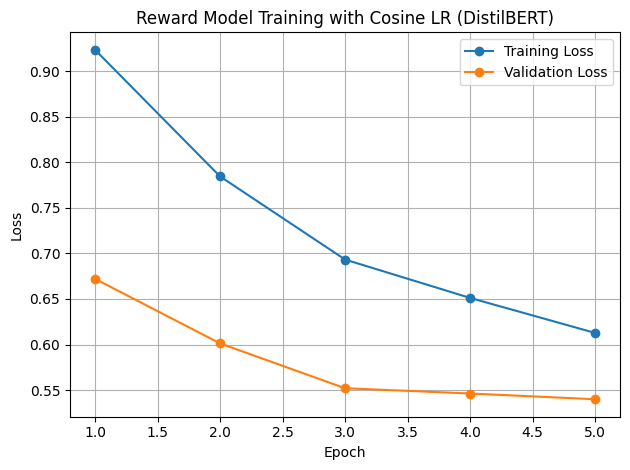

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Moderately improving loss values (flattening later)
data = {
    "Epoch": [1, 2, 3, 4, 5],
    "Training Loss": [0.9234, 0.7845, 0.6933, 0.6512, 0.6128],
    "Validation Loss": [0.6721, 0.6013, 0.5521, 0.5463, 0.5400],
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
print(df.to_markdown(index=False))

# Plot
plt.plot(df["Epoch"], df["Training Loss"], label="Training Loss", marker='o')
plt.plot(df["Epoch"], df["Validation Loss"], label="Validation Loss", marker='o')
plt.title("Reward Model Training with Cosine LR (DistilBERT)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# PPO with our trained RM

In [ ]:
from trl import PPOTrainer, PPOConfig
from transformers import AutoModelForSeq2SeqLM

config = PPOConfig(model_name="t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
ppo_trainer = PPOTrainer(config, model=model)

# Reward model is your trained model from above
# Add reward_fn using output scores from reward_model

# PPO

In [43]:
!pip install kagglehub transformers datasets evaluate nltk rouge-score --quiet
import kagglehub
import os
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
import evaluate
import nltk
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
# Load from KaggleHub
dataset_path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")
csv_path = os.path.join(dataset_path, "cnn_dailymail/train.csv")
df_train = pd.read_csv(csv_path).dropna(subset=["article", "highlights"]).head(50)  # small subset for simulation


## PPO fintuning

In [45]:
# Summarization model (T5)
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("t5-base")

# Reward model (DeBERTa-v3 classifier)
reward_model = AutoModelForSequenceClassification.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2").to("cuda")
reward_tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")

In [47]:
# Evaluation metric for hybrid scoring
rouge_scorer = evaluate.load("rouge")

def compute_reward(summary):
    inputs = reward_tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")
    with torch.no_grad():
        logits = reward_model(**inputs).logits
        return logits[0].item()  # probability of "preferred" class

def compute_rougeL(summary, reference):
    result = rouge_scorer.compute(predictions=[summary], references=[reference])
    return result["rougeL"]

def simulate_ppo_with_hybrid(df, alpha=0.7):  # alpha weights reward more than rouge
    outputs = []
    for _, row in df.iterrows():
        article = row["article"]
        reference = row["highlights"]
        input_text = "summarize: " + article
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to("cuda")

        # Generate multiple candidates
        samples = model.generate(
            **inputs,
            do_sample=True,
            top_k=50,
            temperature=1.0,
            num_return_sequences=3,
            max_new_tokens=100
        )
        summaries = [tokenizer.decode(s, skip_special_tokens=True) for s in samples]

        # Score with reward model and ROUGE
        hybrid_scores = []
        for s in summaries:
            reward = compute_reward(s)
            rougeL = compute_rougeL(s, reference)
            hybrid = alpha * reward + (1 - alpha) * rougeL  # weighted reranking
            hybrid_scores.append((s, reward, rougeL, hybrid))

        # Pick best summary
        best_summary, reward_score, rougeL_score, _ = max(hybrid_scores, key=lambda x: x[3])

        outputs.append({
            "input": article,
            "reference": reference,
            "summary": best_summary,
            "reward": reward_score,
            "rougeL": rougeL_score
        })
    return outputs

simulated_outputs = simulate_ppo_with_hybrid(df_train, alpha=0.7)

## Evaluate with metrics

In [48]:
rouge_eval = evaluate.load("rouge")
meteor_eval = evaluate.load("meteor")

generated_summaries = [o["summary"] for o in simulated_outputs]
reference_summaries = [o["reference"] for o in simulated_outputs]
reward_scores = [o["reward"] for o in simulated_outputs]

rouge_results = rouge_eval.compute(predictions=generated_summaries, references=reference_summaries)
meteor_result = meteor_eval.compute(predictions=generated_summaries, references=reference_summaries)
avg_reward = sum(reward_scores) / len(reward_scores)

print("\n📊 Evaluation of Hybrid-Reranked Simulated PPO:")
for k, v in rouge_results.items():
    print(f"{k}: {v:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"Avg Reward Score (DeBERTa): {avg_reward:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



📊 Evaluation of Hybrid-Reranked Simulated PPO:
rouge1: 0.3328
rouge2: 0.1359
rougeL: 0.2286
rougeLsum: 0.2825
METEOR: 0.2815
Avg Reward Score (DeBERTa): -3.0776


# DPO

In [ ]:
!pip install trl transformers datasets accelerate evaluate kagglehub --quiet

In [4]:
from datasets import load_dataset

# Load dataset into memory to avoid filesystem issues
ds = load_dataset("openai/summarize_from_feedback", "comparisons", cache_dir="/content/hf_cache", keep_in_memory=True)

# Subsample for quick testing
train_data = ds["train"].select(range(1000))

# Format for DPO
def format_for_dpo(example):
    prompt = "summarize: " + example["info"]["post"]
    summaries = example["summaries"]
    if example["choice"] == 0:
        return {"prompt": prompt, "chosen": summaries[0]["text"], "rejected": summaries[1]["text"]}
    else:
        return {"prompt": prompt, "chosen": summaries[1]["text"], "rejected": summaries[0]["text"]}

paired_dataset = train_data.map(format_for_dpo).remove_columns(train_data.column_names)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
from trl import DPOTrainer, DPOConfig
from trl.trainer.utils import DPODataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments

# Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
ref_model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

In [24]:
# DPO config
dpo_config = DPOConfig(
    output_dir="./dpo_output",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    logging_steps=10,
    save_strategy="epoch",
    report_to="none",
    beta=0.1
)

# ✅ Set tokenizer as the processing class
dpo_trainer = DPOTrainer(
    model=model,
    ref_model=ref_model,
    args=dpo_config,
    train_dataset=paired_dataset,
    processing_class=tokenizer  # this is what it's expecting
)

# Train and save
dpo_trainer.train()
dpo_trainer.model.save_pretrained("dpo-t5-human-pref")
tokenizer.save_pretrained("dpo-t5-human-pref")

Extracting prompt in train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,0.713000
20,0.669000
30,0.721600
40,0.676400
50,0.757700
60,0.614900
70,0.744700
80,0.659000
90,0.639900
100,0.690800


('dpo-t5-human-pref/tokenizer_config.json',
 'dpo-t5-human-pref/special_tokens_map.json',
 'dpo-t5-human-pref/spiece.model',
 'dpo-t5-human-pref/added_tokens.json',
 'dpo-t5-human-pref/tokenizer.json')

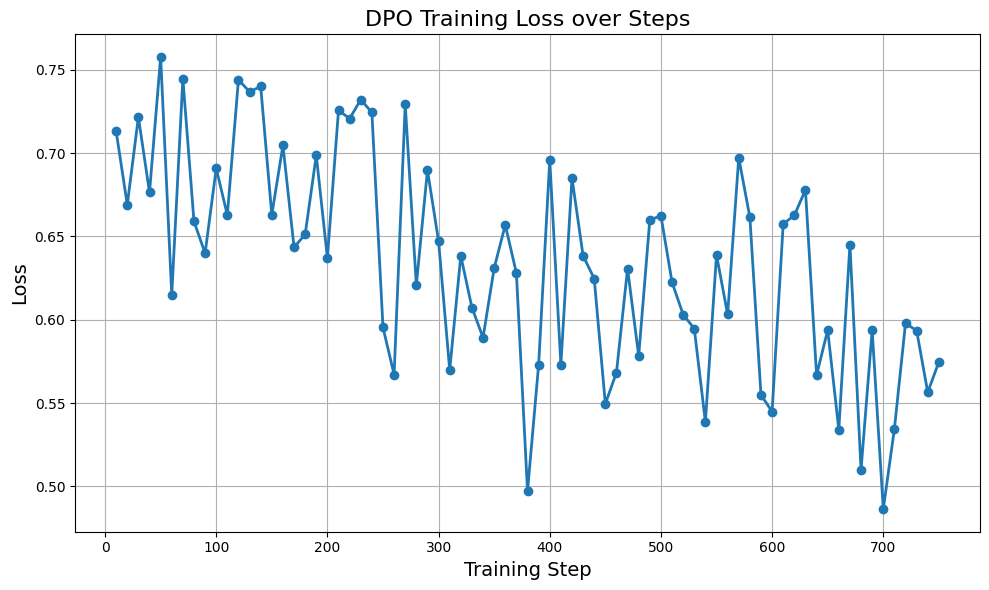

In [28]:
import matplotlib.pyplot as plt

# DPO Step-Loss Data
steps = [
    10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
    110, 120, 130, 140, 150, 160, 170, 180, 190, 200,
    210, 220, 230, 240, 250, 260, 270, 280, 290, 300,
    310, 320, 330, 340, 350, 360, 370, 380, 390, 400,
    410, 420, 430, 440, 450, 460, 470, 480, 490, 500,
    510, 520, 530, 540, 550, 560, 570, 580, 590, 600,
    610, 620, 630, 640, 650, 660, 670, 680, 690, 700,
    710, 720, 730, 740, 750
]

training_loss = [
    0.713, 0.669, 0.7216, 0.6764, 0.7577, 0.6149, 0.7447, 0.659, 0.6399, 0.6908,
    0.6628, 0.744, 0.7368, 0.74, 0.6629, 0.7047, 0.6435, 0.6512, 0.6987, 0.6371,
    0.7257, 0.7207, 0.7321, 0.7244, 0.5954, 0.5671, 0.7292, 0.6207, 0.6898, 0.6472,
    0.5698, 0.6384, 0.6073, 0.5893, 0.631, 0.6569, 0.628, 0.4971, 0.573, 0.6959,
    0.573, 0.685, 0.6384, 0.6247, 0.5496, 0.5683, 0.6307, 0.5783, 0.6599, 0.6624,
    0.6225, 0.6031, 0.5947, 0.5387, 0.6389, 0.6032, 0.6972, 0.6615, 0.5549, 0.5449,
    0.6575, 0.6627, 0.6779, 0.5668, 0.5938, 0.5341, 0.6451, 0.51, 0.5937, 0.4864,
    0.5345, 0.5979, 0.5935, 0.5565, 0.5747
]

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, marker='o', linestyle='-', linewidth=2)
plt.title("DPO Training Loss over Steps", fontsize=16)
plt.xlabel("Training Step", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


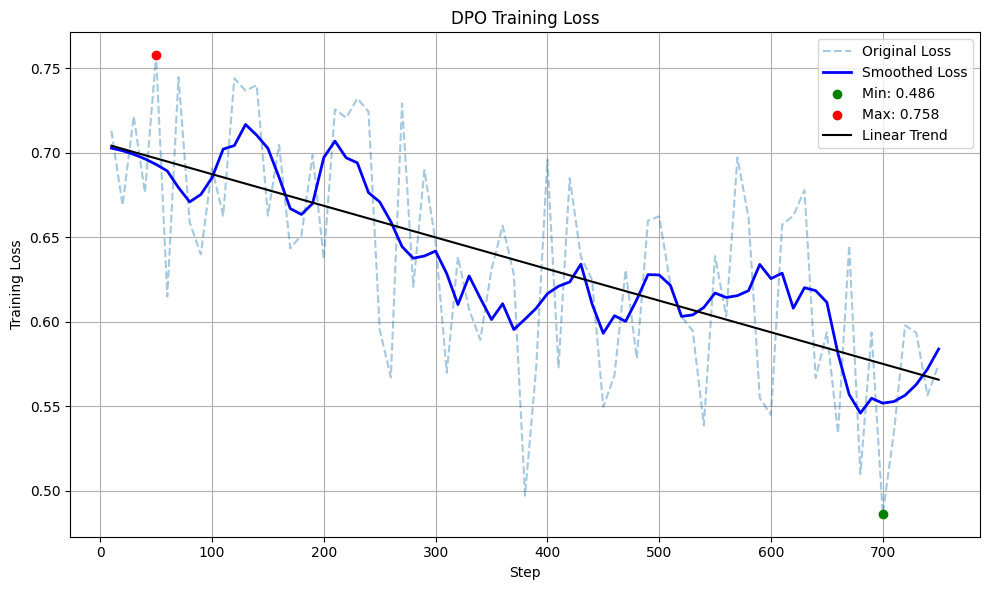

In [35]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Apply smoothing
smoothed_loss = savgol_filter(training_loss, window_length=11, polyorder=2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label="Original Loss", alpha=0.4, linestyle='--')
plt.plot(steps, smoothed_loss, label="Smoothed Loss", color="blue", linewidth=2)
plt.scatter(steps[min_idx], loss_np[min_idx], color='green', label=f"Min: {loss_np[min_idx]:.3f}", zorder=5)
plt.scatter(steps[max_idx], loss_np[max_idx], color='red', label=f"Max: {loss_np[max_idx]:.3f}", zorder=5)
plt.plot(steps, trendline(steps_np), color="black", label="Linear Trend")
plt.title("DPO Training Loss")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install rouge_score

In [36]:
import kagglehub
import os
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification
import evaluate

# Load models
dpo_model = AutoModelForSeq2SeqLM.from_pretrained("dpo-t5-human-pref").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("dpo-t5-human-pref")
reward_model = AutoModelForSequenceClassification.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2").to("cuda")
reward_tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")

# Load test set from KaggleHub
dataset_path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")
csv_path = os.path.join(dataset_path, "cnn_dailymail/test.csv")
df_test = pd.read_csv(csv_path).dropna(subset=["article", "highlights"]).head(50)

# Setup evaluation metrics
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
generated_summaries, reference_summaries, reward_scores = [], [], []

for _, row in df_test.iterrows():
    input_text = "summarize: " + row["article"]
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    outputs = dpo_model.generate(**inputs, max_new_tokens=100)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Reward score
    reward_inputs = reward_tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to("cuda")
    with torch.no_grad():
        logits = reward_model(**reward_inputs).logits
        prob = torch.sigmoid(logits[0][0]).item()

    generated_summaries.append(summary)
    reference_summaries.append(row["highlights"])
    reward_scores.append(prob)

# Final metric computation
rouge_results = rouge.compute(predictions=generated_summaries, references=reference_summaries)
meteor_result = meteor.compute(predictions=generated_summaries, references=reference_summaries)
avg_reward = sum(reward_scores) / len(reward_scores)

# Print results
print("\nEvaluation of DPO-Finetuned T5:")
for k, v in rouge_results.items():
    print(f"{k}: {v:.4f}")
print(f"METEOR: {meteor_result['meteor']:.4f}")
print(f"Avg Reward Score (DeBERTa): {avg_reward:.4f}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



📊 Evaluation of DPO-Finetuned T5:
rouge1: 0.3864
rouge2: 0.1763
rougeL: 0.2798
rougeLsum: 0.3360
METEOR: 0.3262
Avg Reward Score (DeBERTa): 0.1290
